# Trabalho 1 - MC853B

**Alunos:** 

Lucca Miranda Nunes - 230554

Luiz Felipe Corradini Rego Costa - 230613

Pablo Henrique Almeida Mendes - 230977




**Doença de notificação compulsória escolhida:** Esquistossomose

****

## 1) Upload e investigação dos dados

### 1.1) Análise Exploratória dos dados

Os dados escolhidos para treinamento foram os da doença esquistossomose dos anos de 2020, 2021, 2022 e 2023. Os anos de 2024 em diante não estavam disponibilizados na base do SINAN. Todos os dados estão no diretório source/csv.

In [73]:
import pandas as pd

esq_19 = pd.read_csv('../source/csv/ESQUBR19.csv')
esq_20 = pd.read_csv('../source/csv/ESQUBR20.csv')
esq_21 = pd.read_csv('../source/csv/ESQUBR21.csv')
esq_22 = pd.read_csv('../source/csv/ESQUBR22.csv')
esq_23 = pd.read_csv('../source/csv/ESQUBR23.csv')

In [74]:
print(esq_19.shape)
print(esq_20.shape)
print(esq_21.shape)
print(esq_22.shape)
print(esq_23.shape)

(3608, 54)
(1873, 54)
(2395, 54)
(2640, 54)
(3059, 54)


Criando uma coluna para identificar o ano de cada notificação:

In [75]:
esq_19['Ano_atual'] = 2019
esq_20['Ano_atual'] = 2020
esq_21['Ano_atual'] = 2021
esq_22['Ano_atual'] = 2022
esq_23['Ano_atual'] = 2023

In [76]:
esq_23.columns

Index(['Unnamed: 0', 'TP_NOT', 'ID_AGRAVO', 'DT_NOTIFIC', 'SEM_NOT', 'NU_ANO',
       'SG_UF_NOT', 'ID_MUNICIP', 'ID_REGIONA', 'ID_UNIDADE', 'DT_SIN_PRI',
       'SEM_PRI', 'ANO_NASC', 'NU_IDADE_N', 'CS_SEXO', 'CS_GESTANT', 'CS_RACA',
       'CS_ESCOL_N', 'SG_UF', 'ID_MN_RESI', 'ID_RG_RESI', 'ID_PAIS',
       'DT_INVEST', 'ID_OCUPA_N', 'DT_COPRO', 'AN_QUANT', 'OUTROS', 'TRATAM',
       'TRATANAO', 'STCURA1', 'STCURA2', 'STCURA3', 'FORMA', 'TPAUTOCTO',
       'COUFINF', 'COPAISINF', 'COMUNINF', 'NOPROPIN', 'NOCOLINF',
       'DOENCA_TRA', 'EVOLUCAO', 'DT_ENCERRA', 'DT_DIGITA', 'DT_TRANSUS',
       'DT_TRANSDM', 'DT_TRANSSM', 'DT_TRANSRS', 'DT_TRANSSE', 'DT_OBITO',
       'DS_FORMA', 'AN_QUALI', 'DTTRAT', 'DT_RESU3', 'OUTRO_EX', 'Ano_atual'],
      dtype='object')

Precisamos investigar a quantidade de atributos-alvo em cada ano, a fim de garantir balanceamento nas classes dentro dos datasets de treino e de teste:

Valores correspondentes a cada desfecho possível do paciente:


1 - Cura

2 - Não Cura

3 - Óbito por 
esquistossomose 

4 -  Óbito por outras 
causas 

9 - Ignorado


Como iremos usar os dados dos três anos, faz mais sentido concatená-los em um único DataFrame, a fim de realizar a análise em um único comando

In [77]:
esq_total = pd.concat([esq_19, esq_20, esq_21, esq_22, esq_23])
print(esq_total['EVOLUCAO'].value_counts())

# Reajustando os índices
esq_total.reset_index(drop=True, inplace=True)

1.0    7081
9.0    1452
3.0     330
2.0     273
4.0     142
Name: EVOLUCAO, dtype: int64


In [78]:
len(esq_total)

13575

In [79]:
print("Tratamento depois do óbito",len(esq_total[esq_total['DTTRAT'] > esq_total['DT_OBITO']]))

Tratamento depois do óbito 3


Como o problema que iremos prever é de natureza binária (óbito ou não-óbito), precisamos remover todas as instâncias que a resposta foi "Ignorado" ou "Não-Cura". Se o caso foi ignorado, não podemos inserí-lo em nenhuma das duas classes, e a classificação de "Não-Cura" também não torna possível avaliar se o paciente veio a óbito ou não. 

Com isso, levaremos em consideração também os pacientes que vieram a óbito por outros casos no peródo de tempo além da doença.

In [80]:
esq_total = esq_total[(esq_total['EVOLUCAO'] == 1) | (esq_total['EVOLUCAO'] == 3) | (esq_total['EVOLUCAO'] == 4)]
print(esq_total['EVOLUCAO'].value_counts())
print(esq_total.shape)

1.0    7081
3.0     330
4.0     142
Name: EVOLUCAO, dtype: int64
(7553, 55)


---

In [81]:
print(len(esq_total[esq_total['DTTRAT'].notnull()]))

6329


Avaliando a distribuição da diferença dos óbitos para os treinamentos.

In [82]:
print(esq_total['DTTRAT'].isnull().sum())
print(esq_total['DT_OBITO'].isnull().sum())

1224
7081


Primeiramente, obteremos apenas aqueles pacientes cuja data de óbito não é nula.

In [83]:
esq_mortos = esq_total[esq_total['DT_OBITO'].notnull()]
print(len(esq_mortos))

print(len(esq_mortos[esq_mortos['DTTRAT'].notnull()]))

472
91


Pudemos ver que, se considerarmos apenas os pacientes com data de tratamento mapeada, temos 10361 casos totais, sendo 91 mortes, o que dá uma taxa de mortalidade de 0,88%

In [84]:
diff = pd.concat([pd.DataFrame(pd.to_datetime(esq_mortos['DT_OBITO']) - pd.to_datetime(esq_mortos['DTTRAT']), columns=["difference"]),esq_mortos], axis=1)
dead_difference = (diff[diff['difference'].notnull()])
print("Pacientes mortos cuja data de tratamento não é nula: ", len(dead_difference))
dead_difference[['difference', 'DT_OBITO', 'DTTRAT']]

Pacientes mortos cuja data de tratamento não é nula:  91


,difference,DT_OBITO,DTTRAT
173,172 days,2019-07-29,2019-02-07
175,26 days,2019-02-17,2019-01-22
322,88 days,2017-03-08,2016-12-10
323,203 days,2017-08-27,2017-02-05
486,10 days,2019-03-02,2019-02-20
...,...,...,...
11948,3 days,2023-06-26,2023-06-23
11994,9 days,2023-07-20,2023-07-11
12005,-2 days,2023-06-24,2023-06-26
12876,1587 days,2023-09-21,2019-05-18


Problema: apenas 91 pacientes dos 473 mortos especificaram a data de início do tratamento

In [85]:
# Create the 'difference class' column
def classify_difference(diff):
    if diff < pd.Timedelta(days=30):
        return '<30 dias'
    elif diff <= pd.Timedelta(days=60):
        return '<60 dias'
    elif diff <= pd.Timedelta(days=100):
        return '<100 dias'
    elif diff >= pd.Timedelta(days=100):
        return '>100 dias'
    else:
        return "Não classificado"

dead_difference['difference class'] = dead_difference['difference'].apply(classify_difference)

full_difference = diff
full_difference['difference class'] = full_difference['difference'].apply(classify_difference)

/tmp/ipykernel_101451/3646933019.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dead_difference['difference class'] = dead_difference['difference'].apply(classify_difference)


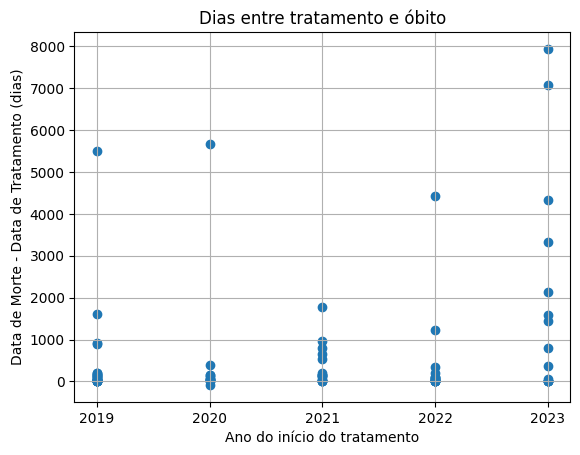

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

plt.scatter(y=dead_difference['difference'].dt.days, x=dead_difference['Ano_atual'])
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title("Dias entre tratamento e óbito")

plt.ylabel("Data de Morte - Data de Tratamento (dias)")
plt.xlabel("Ano do início do tratamento")
plt.grid()


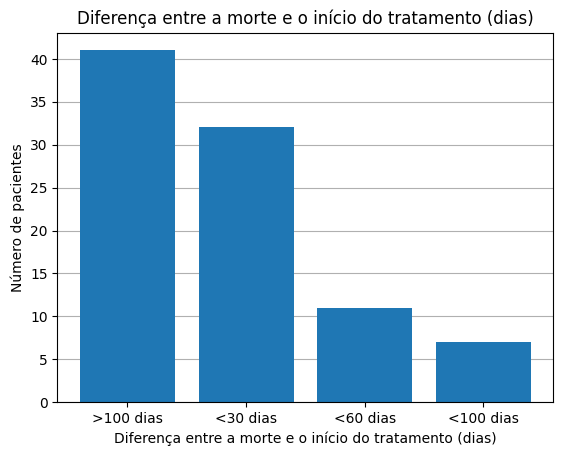

In [87]:
plt.grid(axis='y', zorder=3)
plt.bar(x=dead_difference['difference class'].value_counts().index, height=dead_difference['difference class'].value_counts(), zorder=2)

plt.title("Diferença entre a morte e o início do tratamento (dias)")
plt.ylabel("Número de pacientes")
plt.xlabel("Diferença entre a morte e o início do tratamento (dias)")
plt.savefig('../figures/diferenca_mortes.png')

Aqui, temos outro problema: dentre os 91 pacientes que especificaram a data de tratamento, 42 tem diferença entre data de tratamento e data de óbito superior à 100 dias.

---

In [88]:
print(f"Porcentagem de mortes por esquistossomose: {len(esq_total[esq_total['EVOLUCAO'].isin([3,4])]) / len(esq_total) * 100 :.2f}%")

Porcentagem de mortes por esquistossomose: 6.25%


Inicialmente, pensamos em filtrar as doenças pela que a data de notificação e a data dos primeiros sintomas tenha diferença de até 40 dias. Porém, como a esquistossomose é uma doença que também apresenta uma fase crônica (que pode durar até 6 meses)[FONTE], então optamos por não utilizar esse critério como excludente de instâncias no dataset. 

### 1.2) Tratamento de dados incorretos

Para garantir que não estaremos inserindo no modelo dados contraditórios, tais como o óbito ser registrado depois da data dos primeiros sintomas ou data de encerramento ser registrada antes dos primeiros sintomas.

In [89]:
# Salvando casos que a data de óbito é não-nula (ou seja, a pessoa veio a óbito)
datas_obito_para_analise = esq_total[['DT_SIN_PRI','DT_NOTIFIC', 'DT_ENCERRA','DT_OBITO','EVOLUCAO']]

datas_obito_nao_nulas = datas_obito_para_analise.filter(['DT_NOTIFIC', 'DT_OBITO','EVOLUCAO']).dropna()

# Datas sem retirar óbitos nulos 
datas_para_analise = esq_total[['DT_SIN_PRI','DT_NOTIFIC', 'DT_ENCERRA','EVOLUCAO']]

datas_nao_nulas = datas_para_analise.filter(['DT_NOTIFIC','EVOLUCAO']).dropna()

datas_obito_nao_nulas

,DT_NOTIFIC,DT_OBITO,EVOLUCAO
17,2019-01-04,2018-12-27,3.0
59,2019-01-09,2018-02-21,3.0
80,2019-01-11,2017-05-11,3.0
89,2019-01-13,2019-01-06,3.0
93,2019-01-14,2017-11-22,3.0
...,...,...,...
13423,2023-12-04,2023-06-17,3.0
13484,2023-12-12,2023-12-08,3.0
13502,2023-12-14,2023-02-11,3.0
13511,2023-12-18,2023-12-15,3.0


In [90]:

# Analisando os casos que os óbitos ocorreram antes da data de notificação
diferenca_obitos = datas_obito_nao_nulas.apply(lambda x: pd.to_datetime(x['DT_OBITO']) - pd.to_datetime(x['DT_NOTIFIC']), axis=1)
diferenca_obitos = diferenca_obitos.apply(lambda x: x.days)

diferenca_obitos

17        -8
59      -322
80      -610
89        -7
93      -418
        ... 
13423   -170
13484     -4
13502   -306
13511     -3
13512   -293
Length: 472, dtype: int64

In [91]:

obitos_negativos = diferenca_obitos[diferenca_obitos < 0]

print("Casos que o óbito foi registrado antes da notificação: ",diferenca_obitos[diferenca_obitos < 0].count())

# Analisando os casos que a data de encerramento foi registrada antes dos primeiros sintomas
diferenca_notifica = datas_para_analise.apply(lambda x: pd.to_datetime(x['DT_ENCERRA']) - pd.to_datetime(x['DT_SIN_PRI']), axis=1)
diferenca_notifica = diferenca_notifica.apply(lambda x: x.days)  
print("Casos que a data de encerramento foi registrada antes dos primeiros sintomas: ",diferenca_notifica[diferenca_notifica < 0].count())


Casos que o óbito foi registrado antes da notificação:  271
Casos que a data de encerramento foi registrada antes dos primeiros sintomas:  0


Pudemos ver que um número considerável de óbitos foram registrados depois da data de notificação, ou seja, são dados notificados incorretamente, e por isso, temos que removê-los.

In [92]:
obitos_negativos.index

Int64Index([   17,    59,    80,    89,    93,    94,   116,   128,   139,
              262,
            ...
            13245, 13246, 13254, 13277, 13330, 13423, 13484, 13502, 13511,
            13512],
           dtype='int64', length=271)

In [93]:
print(esq_total.shape)
morreu_tot = esq_total.drop(obitos_negativos.index, axis=0)
print(morreu_tot.value_counts())
print(esq_total.drop(obitos_negativos.index, axis=0).shape)

(7553, 55)
Series([], dtype: int64)
(7282, 55)


****

## 2) Pré-processamento dos dados

Podemos ver que, pelo número elevado de colunas, será necessário realizar uma análise quanto às colunas necessárias, para posteriormente avaliar se o total de instâncias apresentadas nos três anos serão suficientes para treinar o modelo.

### 2.1) Removendo Colunas desnecessárias

O primeiro passo para pré-processar será **remover colunas desnecessárias do dataset**. 

Depois de uma primeira análise, a equipe selecionou 11 colunas que julgamos como mais relevantes para o treinamento do modelo:


*colocar info das colunas*


In [94]:
esq_total.columns

Index(['Unnamed: 0', 'TP_NOT', 'ID_AGRAVO', 'DT_NOTIFIC', 'SEM_NOT', 'NU_ANO',
       'SG_UF_NOT', 'ID_MUNICIP', 'ID_REGIONA', 'ID_UNIDADE', 'DT_SIN_PRI',
       'SEM_PRI', 'ANO_NASC', 'NU_IDADE_N', 'CS_SEXO', 'CS_GESTANT', 'CS_RACA',
       'CS_ESCOL_N', 'SG_UF', 'ID_MN_RESI', 'ID_RG_RESI', 'ID_PAIS',
       'DT_INVEST', 'ID_OCUPA_N', 'DT_COPRO', 'AN_QUANT', 'OUTROS', 'TRATAM',
       'TRATANAO', 'STCURA1', 'STCURA2', 'STCURA3', 'FORMA', 'TPAUTOCTO',
       'COUFINF', 'COPAISINF', 'COMUNINF', 'NOPROPIN', 'NOCOLINF',
       'DOENCA_TRA', 'EVOLUCAO', 'DT_ENCERRA', 'DT_DIGITA', 'DT_TRANSUS',
       'DT_TRANSDM', 'DT_TRANSSM', 'DT_TRANSRS', 'DT_TRANSSE', 'DT_OBITO',
       'DS_FORMA', 'AN_QUALI', 'DTTRAT', 'DT_RESU3', 'OUTRO_EX', 'Ano_atual'],
      dtype='object')

In [95]:
# Lista das colunas conforme dicionário SINAN
colunas_selecionadas = [
    'CS_GESTANT',                     
    'AN_QUANT',
    'AN_QUALI',            
    'TRATAM', 
    'FORMA',      
    'CS_ESCOL_N', 
    'CS_SEXO',  
    'ANO_NASC',
    'COUFINF',
    'EVOLUCAO',
    'Ano_atual'
]

# Seleção das colunas
esq_filtrado = esq_total[colunas_selecionadas]

esq_filtrado.head()


,CS_GESTANT,AN_QUANT,AN_QUALI,TRATAM,FORMA,CS_ESCOL_N,CS_SEXO,ANO_NASC,COUFINF,EVOLUCAO,Ano_atual
0,6,0.0,1.0,1.0,1.0,4.0,M,1994.0,29.0,1.0,2019
1,6,1.0,1.0,1.0,1.0,5.0,M,1985.0,31.0,1.0,2019
3,6,0.0,3.0,1.0,1.0,9.0,M,1997.0,31.0,1.0,2019
4,6,0.0,3.0,1.0,1.0,9.0,M,1992.0,32.0,1.0,2019
5,5,1.0,1.0,1.0,1.0,0.0,F,1956.0,NaN,1.0,2019


Renomeando as colunas selecionadas para garantir melhor entendimento:

In [96]:
novos_nomes_doenças = {
    'CS_GESTANT': 'Gestante',
    'AN_QUANT': 'Quantidade ovos encontrados',
    'AN_QUALI': 'Exame_qualitativo',
    'TRATAM': 'Tratamento realizado',
    'FORMA': 'Forma clínica',
    'CS_ESCOL_N': 'Escolaridade',
    'CS_SEXO': 'Sexo',
    'ANO_NASC': 'Ano de nascimento',
    'COUFINF': 'Unidade Federativa',
    'EVOLUCAO': 'Resultado'

}

esq_filtrado = esq_filtrado.rename(columns=novos_nomes_doenças)

print(esq_filtrado.shape)
esq_filtrado.head()

(7553, 11)


,Gestante,Quantidade ovos encontrados,Exame_qualitativo,Tratamento realizado,Forma clínica,Escolaridade,Sexo,Ano de nascimento,Unidade Federativa,Resultado,Ano_atual
0,6,0.0,1.0,1.0,1.0,4.0,M,1994.0,29.0,1.0,2019
1,6,1.0,1.0,1.0,1.0,5.0,M,1985.0,31.0,1.0,2019
3,6,0.0,3.0,1.0,1.0,9.0,M,1997.0,31.0,1.0,2019
4,6,0.0,3.0,1.0,1.0,9.0,M,1992.0,32.0,1.0,2019
5,5,1.0,1.0,1.0,1.0,0.0,F,1956.0,NaN,1.0,2019


### 2.2) Selecionando os dados a serem usados

In [97]:
esq_valid = esq_filtrado[(esq_filtrado['Resultado'] == 1) | (esq_filtrado['Resultado'] == 3) | (esq_filtrado['Resultado'] == 4)]
esq_valid['Resultado'].value_counts()

1.0    7081
3.0     330
4.0     142
Name: Resultado, dtype: int64

In [98]:
print(f"Porcentagem de mortes por esquistossomose: {len(esq_valid[esq_valid['Resultado'] == 3]) / len(esq_valid) * 100 :.2f}%")

Porcentagem de mortes por esquistossomose: 4.37%


In [99]:
print(f"Porcentagem de mortes: {len( esq_filtrado[(esq_filtrado['Resultado'] == 3) | (esq_filtrado['Resultado'] == 4)] ) / len(esq_valid) * 100 :.2f}%")

Porcentagem de mortes: 6.25%


### 2.3) Tratamento de atributos categóricos

Primeiramente, vamos visualizar nossos dados a fim de transformar os atributos categóricos em numéricos:

In [100]:
esq_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7553 entries, 0 to 13574
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gestante                     7553 non-null   int64  
 1   Quantidade ovos encontrados  7553 non-null   float64
 2   Exame_qualitativo            6002 non-null   float64
 3   Tratamento realizado         7553 non-null   float64
 4   Forma clínica                5762 non-null   float64
 5   Escolaridade                 6839 non-null   float64
 6   Sexo                         7553 non-null   object 
 7   Ano de nascimento            7504 non-null   float64
 8   Unidade Federativa           6035 non-null   float64
 9   Resultado                    7553 non-null   float64
 10  Ano_atual                    7553 non-null   int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 708.1+ KB


Podemos notar que, apesar de que o tipo de muitos dos atributos esteja definido como 'float', de acordo com o dicionário da doença, cada número representa uma característica distinta. Por isso, a ideia será realizar o One-Hot encoding para separar tais atributos categóricos.

#### 2.3.1) Gestante

In [101]:
esq_valid['Gestante'].value_counts()

6    5304
5    2043
9     158
2      18
1      13
4      12
3       5
Name: Gestante, dtype: int64

In [102]:
# Para gestante, consideraremos apenas como uma variável binária. 
# 5, 6 e 9 indica que não é gestante, e todas as demais indicam que é gestante

esq_valid['nao_gestante'] = (esq_valid['Gestante'].isin([5, 6, 9])).astype(int)
esq_valid['gestante'] = (~esq_valid['Gestante'].isin([5, 6, 9])).astype(int)


In [103]:
esq_valid[esq_valid['nao_gestante'] == 0]['Resultado'].value_counts()

1.0    48
Name: Resultado, dtype: int64

Após análise do fator gestante, é possível notar que um número inexpressivo de pessoas na base de dados são gestantes, e nenhuma delas apresenta veio a óbito. Adicionar tal feature na base pode corroborar com o viés do modelo, por isso optamos por retirar a categoria da base de dados.

In [104]:
esq_valid = esq_valid.drop(columns=['Gestante', 'nao_gestante','gestante'])

#### 2.3.2) Quantidade de ovos de schistossoma encontrados

Para o atributo "Quantidade de Ovos encontrados", este já está em forma binária, indicando se não foram encontrados ovos da Schistossoma no exame de fezes (0) ou se foram encontrados (1)

In [105]:
esq_valid['Quantidade ovos encontrados'].value_counts()

0.0    4003
1.0    3550
Name: Quantidade ovos encontrados, dtype: int64

In [106]:
# Transformando o atributo de float para inteiro
esq_valid['Quantidade ovos encontrados'] = esq_valid['Quantidade ovos encontrados'].astype(int)

#### 2.3.3) Exame qualitativo

Já para o atributo "Resultado exame ovos qualitativo", que indica o resultado (1=Positivo, 2=Negativo e 3=Não realizado), como são apresentadas mais de duas categorias, será necessário transformar em mais colunas.

Além disso, como existem muitos valores nulos na coluna, vamos atribuí-los a uma quarta categoria: Desconhecido

In [107]:
print(esq_valid['Exame_qualitativo'].value_counts())
print("Valores nulos: ", esq_valid['Exame_qualitativo'].isna().sum())

1.0    3242
3.0    2152
2.0     608
Name: Exame_qualitativo, dtype: int64
Valores nulos:  1551


In [108]:
# Adicionando "Desconhecido"
esq_valid['Exame_qualitativo'].fillna("Desconhecido", inplace=True)

In [109]:
# Definindo valores numéricos como texto
esq_valid['Exame_qualitativo'].replace(1, "Positivo", inplace=True)
esq_valid['Exame_qualitativo'].replace(2, "Negativo", inplace=True)
esq_valid['Exame_qualitativo'].replace(3, "Nao_Realizado", inplace=True)

In [110]:
# Criando novas colunas com one-hot-encoding
df_onehot = pd.get_dummies(esq_valid['Exame_qualitativo'], prefix='Exame', dtype=int)

# Concatenando com o DataFrame original
esq_valid = pd.concat([esq_valid, df_onehot], axis=1)

# Removendo a coluna original
esq_valid.drop(columns=['Exame_qualitativo'], inplace=True)

#### 2.3.4) Tratamento realizado

A categoria apresenta o tratamento que foi realizado pelo paciente no combate à doença, sendo 1=  Sim  –  Praziquantel,  2=  Sim,  Oxaminiquine,  3=  Não  ou  9=  Ignorado

In [111]:
print(esq_valid['Tratamento realizado'].value_counts())
print("Valores nulos: ", esq_valid['Tratamento realizado'].isna().sum())

1.0    6298
3.0     724
9.0     500
2.0      31
Name: Tratamento realizado, dtype: int64
Valores nulos:  0


Como não existem valores nulos, podemos apenas atribuir a cada valor numérico a string relativa ao output:

In [112]:
# Substituição dos valores numéricos por rótulos
esq_valid['Tratamento realizado'].replace(
    {
        1: "Sim_Praziquantel",
        2: "Sim_Oxaminiquine", 
        3: "Nao",
        9: "Ignorado"
    }, 
    inplace=True
)

In [113]:
# Criar colunas one-hot para cada categoria
df_onehot = pd.get_dummies(
    esq_valid['Tratamento realizado'], 
    prefix='Tratamento', 
    dtype=int
)

# Concatenar com o DataFrame original
esq_valid = pd.concat([esq_valid, df_onehot], axis=1)

# Remover a coluna original (opcional)
esq_valid.drop(columns=['Tratamento realizado'], inplace=True)

#### 2.3.5) Forma clínica avaliada

In [114]:
print(esq_valid['Forma clínica'].value_counts())
print("Valores nulos: ", esq_valid['Forma clínica'].isna().sum())

1.0    4173
5.0     491
3.0     425
2.0     376
4.0     297
Name: Forma clínica, dtype: int64
Valores nulos:  1791


In [115]:
# Substituindo valores nulos para "Nao_especificado"
esq_valid['Forma clínica'].fillna("Nao_especificado", inplace=True)

In [116]:
# Dicionário de mapeamento dos valores
mapeamento_forma = {
    1: "Intestinal",
    2: "Hepato_Intestinal",
    3: "Hepato_Esplenica",
    4: "Aguda",
    5: "Outra"
}

# Substituição inplace
esq_valid['Forma clínica'].replace(mapeamento_forma, inplace=True)

In [117]:
# Criando colunas one-hot
df_onehot = pd.get_dummies(
    esq_valid['Forma clínica'],
    prefix='Forma',     
    dtype=int          
)

# Concatenar com o DataFrame original
esq_valid = pd.concat([esq_valid, df_onehot], axis=1)

# Remover a coluna original
esq_valid.drop(columns=['Forma clínica'], inplace=True)

#### 2.3.6) Escolaridade

In [118]:
print(esq_valid['Escolaridade'].value_counts())
print("Valores nulos: ", esq_valid['Escolaridade'].isna().sum())

9.0     1555
6.0     1151
1.0      885
3.0      881
5.0      525
2.0      516
4.0      513
8.0      267
0.0      231
10.0     213
7.0      102
Name: Escolaridade, dtype: int64
Valores nulos:  714


Como o campo escolaridade apresenta uma cardinalidade lógica, ou seja, o 1 = 1º a 4º série incompleta e 8 = Educação superior completa, podemos considerá-lo como um atributo numérico, e não é necessário realizar o One-Hot-Encoding.

Porém, como os atributos 9 = Ignorado e 10 = Não se aplica, transformaremos-os em 0 para garantir que não sejam considerados com uma cardinalidade maior que a Educação superior completa.

In [119]:
esq_valid['Escolaridade'].fillna(0, inplace=True)
esq_valid['Escolaridade'].replace(9, 0, inplace=True)
esq_valid['Escolaridade'].replace(10, 0, inplace=True)
esq_valid['Escolaridade'] = esq_valid['Escolaridade'].astype(int)

#### 2.3.7) Sexo

In [120]:
esq_valid['Sexo'].value_counts()

M    4531
F    3020
I       2
Name: Sexo, dtype: int64

Como temos apenas dois valores "Ignorado", podemos desconsiderá-los:

In [121]:
esq_valid['Sexo'].drop(esq_valid[esq_valid['Sexo'] == "I"].index, inplace=True)

In [122]:
esq_valid['Sexo'].replace("M", 0, inplace=True)
esq_valid['Sexo'].replace("F", 1, inplace=True)

#### 2.3.8) Ano de Nascimento

In [123]:
print(esq_valid['Ano de nascimento'].value_counts())
print("Valores nulos: ", esq_valid['Ano de nascimento'].isna().sum())

1973.0    159
1978.0    159
1982.0    154
1976.0    154
1981.0    152
         ... 
1927.0      1
1926.0      1
1906.0      1
1922.0      1
1923.0      1
Name: Ano de nascimento, Length: 104, dtype: int64
Valores nulos:  49


In [124]:
# Removendo as 31 pessoas sem um ano de nascimento definido
esq_valid.dropna(subset=['Ano de nascimento'], inplace=True)

Primeiramente, precisamos extrair a idade de cada paciente conforme o ano de nascimento. 

Como foram concatenados datasets de 4 anos diferentes, usaremos a coluna "Ano_atual" a fim de calcular a idade correta de cada paciente:

In [125]:
esq_valid['Idade'] = (esq_valid['Ano_atual'] - esq_valid['Ano de nascimento']).astype(int)

In [126]:
# Remover as colunas que não serão mais utilizadas
esq_valid.drop(columns=['Ano de nascimento'], inplace=True)

#### 2.3.9) Unidade Federativa

Para a utilização da unidade federativa, a escolha realizada pelo grupo foi dividir por regiões ao invés de por estados, reduzindo a complexidade total do modelo. 

Para isso, é necessário identificar cada estado e atribuí-lo à região correspondente. 

In [127]:
print(esq_valid['Unidade Federativa'].value_counts())
print("Valores nulos: ", esq_valid['Unidade Federativa'].isna().sum())

31.0    3632
29.0     583
26.0     373
32.0     324
27.0     292
25.0     180
28.0     164
35.0     106
33.0      73
41.0      59
23.0      52
21.0      47
15.0      27
24.0      24
11.0      17
52.0       9
51.0       7
50.0       6
17.0       6
53.0       4
42.0       4
22.0       4
43.0       3
13.0       2
Name: Unidade Federativa, dtype: int64
Valores nulos:  1506


Como temos uma quantidade significativa de valores nulos, os definiremos como "Não especificado"

In [128]:
esq_valid['Unidade Federativa'].fillna("Nao_especificado", inplace=True)

Para identificar as fontes, foi preciso acessar a Tabela de Códigos de Municípios do IBGE:

https://www.ibge.gov.br/explica/codigos-dos-municipios.php

In [129]:
replace_uf_para_regiao = {
    11: 'Norte',  # Rondônia
    12: 'Norte',  # Acre
    13: 'Norte',  # Amazonas
    14: 'Norte',  # Roraima
    15: 'Norte',  # Pará
    16: 'Norte',  # Amapá
    17: 'Norte',  # Tocantins
    
    21: 'Nordeste',  # Maranhão
    22: 'Nordeste',  # Piauí
    23: 'Nordeste',  # Ceará
    24: 'Nordeste',  # Rio Grande do Norte
    25: 'Nordeste',  # Paraíba
    26: 'Nordeste',  # Pernambuco
    27: 'Nordeste',  # Alagoas
    28: 'Nordeste',  # Sergipe
    29: 'Nordeste',  # Bahia
    
    31: 'Sudeste',  # Minas Gerais
    32: 'Sudeste',  # Espírito Santo
    33: 'Sudeste',  # Rio de Janeiro
    35: 'Sudeste',  # São Paulo
    
    41: 'Sul',  # Paraná
    42: 'Sul',  # Santa Catarina
    43: 'Sul',  # Rio Grande do Sul
    
    50: 'Centro-Oeste',  # Mato Grosso do Sul
    51: 'Centro-Oeste',  # Mato Grosso
    52: 'Centro-Oeste',  # Goiás
    53: 'Centro-Oeste'   # Distrito Federal
}

In [130]:
# Substituindo os códigos pelas regiões
esq_valid['Unidade Federativa'] = esq_valid['Unidade Federativa'].replace(replace_uf_para_regiao)

# Verificando o resultado
print(esq_valid['Unidade Federativa'].unique())

['Nordeste' 'Sudeste' 'Nao_especificado' 'Sul' 'Centro-Oeste' 'Norte']


Agora, definindo uma coluna por One-Hot encoding para cada região distinta:

In [131]:
# Criando colunas one-hot
df_onehot = pd.get_dummies(
    esq_valid['Unidade Federativa'],
    prefix='Regiao',     
    dtype=int          
)

# Concatenando com o DataFrame original
esq_valid = pd.concat([esq_valid, df_onehot], axis=1)

# Removendo a coluna original
esq_valid.drop(columns=['Unidade Federativa'], inplace=True)

In [132]:
esq_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7504 entries, 0 to 13574
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Quantidade ovos encontrados  7504 non-null   int64  
 1   Escolaridade                 7504 non-null   int64  
 2   Sexo                         7504 non-null   object 
 3   Resultado                    7504 non-null   float64
 4   Ano_atual                    7504 non-null   int64  
 5   Exame_Desconhecido           7504 non-null   int64  
 6   Exame_Nao_Realizado          7504 non-null   int64  
 7   Exame_Negativo               7504 non-null   int64  
 8   Exame_Positivo               7504 non-null   int64  
 9   Tratamento_Ignorado          7504 non-null   int64  
 10  Tratamento_Nao               7504 non-null   int64  
 11  Tratamento_Sim_Oxaminiquine  7504 non-null   int64  
 12  Tratamento_Sim_Praziquantel  7504 non-null   int64  
 13  Forma_Aguda      

In [133]:
print(esq_valid['Regiao_Norte'].value_counts())
print(esq_valid['Regiao_Nordeste'].value_counts())
print(esq_valid['Regiao_Sudeste'].value_counts())
print(esq_valid['Regiao_Sul'].value_counts())
print(esq_valid['Regiao_Centro-Oeste'].value_counts())

0    7452
1      52
Name: Regiao_Norte, dtype: int64
0    5785
1    1719
Name: Regiao_Nordeste, dtype: int64
1    4135
0    3369
Name: Regiao_Sudeste, dtype: int64
0    7438
1      66
Name: Regiao_Sul, dtype: int64
0    7478
1      26
Name: Regiao_Centro-Oeste, dtype: int64


In [134]:
nordeste = esq_valid[esq_valid['Regiao_Nordeste'] == 1]
print("Porcentagem da região nordeste: ", len(nordeste) / len(esq_valid) * 100)
print(f"Taxa de mortalidade da região nordeste: { len(nordeste[nordeste['Resultado'] == 1]) / len(esq_valid) * 100:.2f}%")

Porcentagem da região nordeste:  22.90778251599147
Taxa de mortalidade da região nordeste: 20.59%


In [135]:
ano_2023 = esq_valid[esq_valid['Ano_atual'] == 2023]
print("Porcentagem do ano de 2023: ", len(esq_valid[esq_valid['Ano_atual'] == 2023]) / len(esq_valid) * 100)
print(f"Taxa de mortalidade do ano de 2023: {len(ano_2023[ano_2023['Resultado'] == 1]) / len(esq_valid) * 100:.2f}%")

Porcentagem do ano de 2023:  19.976012793176974
Taxa de mortalidade do ano de 2023: 18.78%


In [136]:
print("Porcentagem de mortes em relação ao total: ", len(esq_valid[esq_valid['Resultado'] == 1]) / len(esq_valid) * 100)

Porcentagem de mortes em relação ao total:  93.77665245202559


Podemos ver que, como a distribuição por região dos casos se mostra muito desbalanceada, talvez não seja ideal realizar a divisão de treino por região. Por isso, optamos por realizar a divisão em função de tempo.

In [137]:
esq_valid["Ano_atual"].value_counts()

2019    2280
2023    1499
2022    1431
2021    1287
2020    1007
Name: Ano_atual, dtype: int64

Podemos verificar que o ano de 2021 apresenta aproximadamente 17.15% das instâncias, o que é suficiente para o conjunto de testes.

Note que a coluna "Resultado" ainda apresenta 3 valores distintos: cura, óbito por esquistossomose e óbito por outras causas.

In [138]:
esq_valid["Resultado"].unique()

array([1., 3., 4.])

Para usarmos *one-hot* encoding na coluna "Resultado", mapeamos os valores correspondentes a cura (1) para 0 e os valores correspondentes a óbito (3 e 4) para 1.

In [139]:
esq_valid['Resultado'] = esq_valid['Resultado'].map({1: 0, 3: 1, 4: 1})


In [140]:
esq_valid["Resultado"].unique()

array([0, 1])

Analisando as colunas e removendo colunas pouco representativas (como colunas que identificam dados vazios) a fim de mitigar o viés no modelo:

In [141]:
esq_valid.columns

Index(['Quantidade ovos encontrados', 'Escolaridade', 'Sexo', 'Resultado',
       'Ano_atual', 'Exame_Desconhecido', 'Exame_Nao_Realizado',
       'Exame_Negativo', 'Exame_Positivo', 'Tratamento_Ignorado',
       'Tratamento_Nao', 'Tratamento_Sim_Oxaminiquine',
       'Tratamento_Sim_Praziquantel', 'Forma_Aguda', 'Forma_Hepato_Esplenica',
       'Forma_Hepato_Intestinal', 'Forma_Intestinal', 'Forma_Nao_especificado',
       'Forma_Outra', 'Idade', 'Regiao_Centro-Oeste',
       'Regiao_Nao_especificado', 'Regiao_Nordeste', 'Regiao_Norte',
       'Regiao_Sudeste', 'Regiao_Sul'],
      dtype='object')

In [142]:
esq_valid.drop(['Exame_Desconhecido', 'Tratamento_Ignorado', 'Forma_Nao_especificado','Regiao_Nao_especificado'], axis=1, inplace=True)

Finalmente, dividimos os dados entre teste e treino.

In [143]:
# Criar conjuntos de teste (2021) e treino (outros anos)
df_teste = esq_valid[esq_valid['Ano_atual'] == 2023].copy()
df_treino = esq_valid[esq_valid['Ano_atual'] != 2023].copy()

# Remover a coluna 'Ano_atual' de ambos os DataFrames
df_teste = df_teste.drop(columns=['Ano_atual'])
df_treino = df_treino.drop(columns=['Ano_atual'])

# Exportar para CSV
df_teste.to_csv('../source/datasets/df_teste.csv', index=False)
df_treino.to_csv('../source/datasets/df_treino.csv', index=False)